# This is the notebook for the code implementing a Resnet18 model.

Because CNN implementations were not taught during class, most of this code was generated using ChatGPT, but I added in code based on concepts from the class to help make it more understandable (metrics and calculations, plots, etc.).

# 1. Imports.

For imports, I needed to use os (to interact with computer's os), numpy (for calculations), cv2 (for computer vision and image processing), matplotlib (for our plots), seaborn (for our confusion matrix), torch (since we decided against tensorflow), torch.nn, torch.nn.functional, torch.utils.data, torchvision, and sklearn.metrics to gather the metrics we wanted to compare between models. I also used PIL to help with image processing.

In [ ]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns


# 2. Handling the Dataset.

Similar to the CNN notebook, we needed to ensure that the YOLO label format was handled correctly, implementing these functions to do so. We also resized the images once again to avoid errors.

In [ ]:
# resize images to avoid errors
IMG_SIZE = 224

# similar functions as earlier
class BrainTumorDataset(Dataset):
    def __init__(self, img_dir, label_dir, transform=None):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transform = transform

        self.img_files = [
            f for f in os.listdir(img_dir)
            if f.endswith(".jpg") and os.path.exists(os.path.join(label_dir, f.replace(".jpg",".txt")))
        ]
        if len(self.img_files) == 0:
            raise RuntimeError(f"No images found in {img_dir} with matching labels")

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_name = self.img_files[idx]
        img_path = os.path.join(self.img_dir, img_name)
        label_path = os.path.join(self.label_dir, img_name.replace(".jpg",".txt"))

        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        with open(label_path, "r") as f:
            label = int(f.readline().strip().split()[0])
        return image, label

# 3. Transforms.

Transform the images to our desired size, assign the paths based on our given dataset, and load the data. Also assign the class names just like before based on the labels.

In [ ]:
# do transforms
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

# assign paths
train_img_dir = "archive/brain-tumor/train/images"
train_label_dir = "archive/brain-tumor/train/labels"
val_img_dir = "archive/brain-tumor/valid/images"
val_label_dir = "archive/brain-tumor/valid/labels"

# dataset loading
train_dataset = BrainTumorDataset(train_img_dir, train_label_dir, transform)
val_dataset = BrainTumorDataset(val_img_dir, val_label_dir, transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

class_names = ["no tumor", "tumor"]

# 4. Get model.

We used a pre-trained ResNet18 to compare to our simple CNN across metrics and performance depending on the amount of layers used.

In [ ]:
# sanity check
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# get model
model = models.resnet18(weights="IMAGENET1K_V1")
model.fc = nn.Linear(512, 2)
model = model.to(device)

# going to measure cross entropy loss as metric
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# using more than 10 epochs for good training
EPOCHS = 12

# 5. Train the model.

Run similar training to the CNN for 12 epochs, and gather metrics.

In [ ]:
# getting both training and validation loss
train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    # train
    model.train()
    running_loss = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
   
    # add to train losses
    train_losses.append(running_loss / len(train_dataset))

    # validation
    model.eval()
    val_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * imgs.size(0)

            preds = torch.argmax(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # add to validation losses
    val_losses.append(val_loss / len(val_dataset))

    acc = accuracy_score(all_labels, all_preds)
    print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {train_losses[-1]:.4f} - Val Loss: {val_losses[-1]:.4f} - Val Acc: {acc:.4f}")

# gather metrics
acc = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds)
rec = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print("\nClassification Report:")
print(classification_report(all_labels, all_preds))
print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1:", f1)


Epoch 1/12 - Train Loss: 0.5879 - Val Loss: 0.8762 - Val Acc: 0.5381
Epoch 2/12 - Train Loss: 0.2259 - Val Loss: 0.8417 - Val Acc: 0.6009
Epoch 3/12 - Train Loss: 0.0763 - Val Loss: 1.1933 - Val Acc: 0.5650
Epoch 4/12 - Train Loss: 0.0691 - Val Loss: 1.0343 - Val Acc: 0.6413
Epoch 5/12 - Train Loss: 0.0856 - Val Loss: 0.8596 - Val Acc: 0.6592
Epoch 6/12 - Train Loss: 0.0775 - Val Loss: 1.5490 - Val Acc: 0.5605
Epoch 7/12 - Train Loss: 0.0871 - Val Loss: 1.2448 - Val Acc: 0.6502
Epoch 8/12 - Train Loss: 0.0414 - Val Loss: 1.4571 - Val Acc: 0.5650
Epoch 9/12 - Train Loss: 0.0802 - Val Loss: 0.8035 - Val Acc: 0.7040
Epoch 10/12 - Train Loss: 0.0824 - Val Loss: 1.1092 - Val Acc: 0.6816
Epoch 11/12 - Train Loss: 0.0479 - Val Loss: 1.8370 - Val Acc: 0.5291
Epoch 12/12 - Train Loss: 0.0663 - Val Loss: 3.3684 - Val Acc: 0.4933


# 6. Confusion matrix.

Generate the confusion matrix from our data.


Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.24      0.38       142
           1       0.41      0.94      0.57        81

    accuracy                           0.49       223
   macro avg       0.64      0.59      0.47       223
weighted avg       0.71      0.49      0.45       223

Accuracy: 0.49327354260089684
Precision: 0.41304347826086957
Recall: 0.9382716049382716
F1: 0.5735849056603773


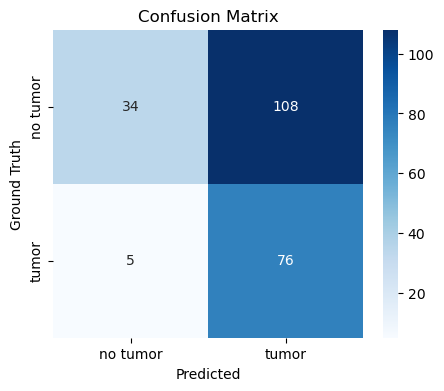

In [ ]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Ground Truth")
plt.show()

# 7. Loss plots.

Plot our loss across the epochs to compare between train and validation.

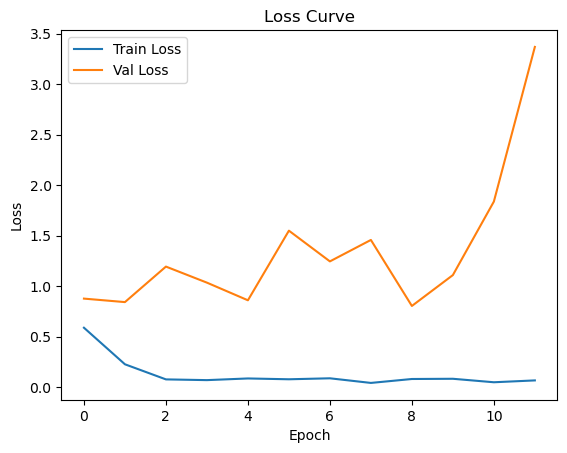

In [ ]:
plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# 8. Visualize with Grad-CAM.

Define the batch gradcam like earlier to visualize our heatmaps for our images.

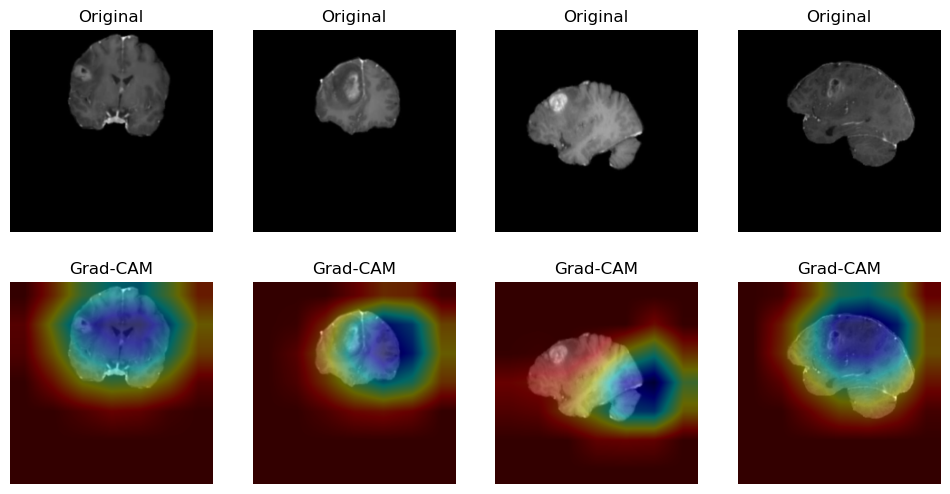

In [ ]:
def gradcam_batch(model, images, target_layer):
    model.eval()
    gradients = []
    activations = []

    # forward hook
    def fw_hook(module, inp, out):
        activations.append(out.detach())
    # backward hook
    def bw_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0].detach())

    handle_fw = target_layer.register_forward_hook(fw_hook)
    handle_bw = target_layer.register_backward_hook(bw_hook)

    cams = []
    for img in images:
        img = img.unsqueeze(0).to(device)
        output = model(img)
        target_class = output.argmax(1).item()
        loss = output[0, target_class]
        model.zero_grad()
        loss.backward()

        # gather activations, gradients, and weights to get the cam
        gradient = gradients[0]
        activation = activations[0]
        weights = gradient.mean(dim=[2,3], keepdim=True)
        cam = (weights * activation).sum(dim=1, keepdim=True)
        cam = F.relu(cam)
        cam = cam.squeeze().cpu().numpy()
        cam = cv2.resize(cam, (IMG_SIZE, IMG_SIZE))
        cam = cam - cam.min()
        cam = cam / cam.max()
        cams.append(cam)

        gradients.clear()
        activations.clear()

    handle_fw.remove()
    handle_bw.remove()
    return cams

# overlay
def overlay_cam(image_tensor, cam):
    img = image_tensor.permute(1,2,0).cpu().numpy()
    img = np.uint8(255 * (img - img.min()) / (img.max() - img.min()))
    heatmap = np.uint8(255 * cam)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
    return overlay

# show batch Grad-CAM for the first 4 validation images
images_batch = [val_dataset[i][0] for i in range(4)]
cams = gradcam_batch(model, images_batch, model.layer4[1].conv2)

plt.figure(figsize=(12,6))
for i, img in enumerate(images_batch):
    plt.subplot(2,4,i+1)
    plt.imshow(img.permute(1,2,0))
    plt.axis("off")
    plt.title("Original")

    plt.subplot(2,4,i+5)
    overlay = overlay_cam(img, cams[i])
    plt.imshow(overlay)
    plt.axis("off")
    plt.title("Grad-CAM")
plt.show()

# Extra: Misclassified images.

Gather the images that were misclassified to see what type of errors the model was most prone to.

In [ ]:
# reassign class names to double check for output (was done earlier)
class_names = ["no tumor", "tumor"]

misclassified = []

# go through validation dataset
for i in range(len(val_dataset)):
    img, label = val_dataset[i]

    # add the batch dimension, and move to the device
    img_tensor = img.unsqueeze(0).to(device)  
    
    # forward pass
    model.eval()
    with torch.no_grad():
        output = model(img_tensor)
        pred = output.argmax(1).item()

    if pred != label:
        misclassified.append((img, label, pred))

    # stop after 9 misclassified images for now
    if len(misclassified) >= 9:
        break

# visualize them
plt.figure(figsize=(10,10))
for i, (img, label, pred) in enumerate(misclassified):
    plt.subplot(3,3,i+1)
    plt.imshow(img.permute(1,2,0))
    plt.title(f"T: {class_names[label]}\nP: {class_names[pred]}")
    plt.axis("off")
plt.tight_layout()
plt.show()
